# Monitor your ML Models using Watson OpenScale

## 1. Setup the Notebook Environment

## 1.1 Install the necessary packages

### Watson OpenScale Python SDK

In [1]:
!pip install ibm-ai-openscale

  Using cached https://files.pythonhosted.org/packages/03/98/35eaf8120851b41110eb339ff6d5f80c51a4fae9e2318f826028c657267e/ibm_ai_openscale-2.1.16-py3-none-any.whl


### Scikit-learn version 0.20

In [2]:
!pip install scikit-learn==0.20.3

  Using cached https://files.pythonhosted.org/packages/5e/82/c0de5839d613b82bddd088599ac0bbfbbbcbd8ca470680658352d2c435bd/scikit_learn-0.20.3-cp36-cp36m-manylinux1_x86_64.whl
  Found existing installation: scikit-learn 0.21.2
    Uninstalling scikit-learn-0.21.2:
      Successfully uninstalled scikit-learn-0.21.2


### Watson Machine Learning Python SDK

In [3]:
!pip install watson-machine-learning-client -U

  Using cached https://files.pythonhosted.org/packages/ac/5c/be0d3efe27704bbd43481b7de364ade8c686e867617caba8654989e0864b/watson_machine_learning_client-1.0.375-py3-none-any.whl


Restart the Notebook after Installing the required packages. By clicking on `Kernel>Restart`

## 1.2 Import Packages

In [5]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn import preprocessing
from sklearn import svm, metrics
from scipy import sparse
from watson_machine_learning_client import WatsonMachineLearningAPIClient
from sklearn.preprocessing import StandardScaler, LabelEncoder, Imputer, OneHotEncoder
import json
import ibm_db


import pandas as pd
import numpy as np

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV

from ibm_ai_openscale import APIClient4ICP
from ibm_ai_openscale.engines import *
from ibm_ai_openscale.utils import *
from ibm_ai_openscale.supporting_classes import PayloadRecord, Feature
from ibm_ai_openscale.supporting_classes.enums import *

## 2. Configuration

### 2.1 Global Variables

In [6]:
MODEL_NAME="AIOS_Model"
DEPLOYMENT_NAME="AIOS_Deployment"
# Ensure you create a an empty Schema and store the name in this variable
SCHEMA_NAME="DB2INST1"

### 2.2 Add Dataset

Select the `Insert Pandas Dataframe` option, after selecting the below cell. Ensure the variable name is `df_data_1`

,outgoing_site_id,Start_Time_MM_DD_YYYY,Start_Time_HH_MM_SS_s,Call_Service_Duration,_conds,_dewptm,_fog,_hail,_hum,_pressurem,total number_of_calls,total call duration (min),Traffic,lat,long,Call_Drop_Count,Total_Calls,Call_Drop_Perc,Call_Drop_Actual
0,63383,01/01/17,00:00 to 4:00,325,Smoke,11,0,0,72,1019.0,631,455,High,12.972967,77.609317,11100,12234,0.907308,0
1,63383,01/01/17,4:00 to 8:00,424,Shallow Fog,11,1,0,82,1019.0,540,239,High,12.972967,77.609317,11100,12234,0.907308,0
2,63383,01/01/17,8:00 to 12:00,161,Shallow Fog,11,1,0,88,1020.0,423,309,Medium,12.972967,77.609317,11100,12234,0.907308,0
3,63383,01/01/17,12:00 to 16:00,383,Fog,11,1,0,100,1020.0,650,428,High,12.972967,77.609317,11100,12234,0.907308,0
4,63383,01/01/17,16:00 to 20:00,330,Fog,8,1,0,93,1019.0,240,443,Low,12.972967,77.609317,11100,12234,0.907308,0


### 2.3 Add your WML Credentials

In [35]:
WML_CREDENTIALS ={}

### 2.4 Update your AIOS Credentials

In [36]:
WOS_CREDENTIALS={
    "url": "<instance-url>",
    "username": "<username-of-CP4D-instance>",
    "password": "<password-of-CP4D-instance>"
}

### 2.5 Add your Db credentials

In [37]:

DATABASE_CREDENTIALS = {
    "hostname": "DB-Server-IP",
    "username": "DB-username",
    "password": "DB-Pwd",
    "port": xxxx,
    "db": "DB-name",
    
}


## 3. Create the Call Drop Model using Scikit-Learn

In [38]:
X=df_data_1.drop(['Call_Drop_Actual'], axis=1)
y=df_data_1.loc[:, 'Call_Drop_Actual']

In [39]:

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)



In [40]:
'''Add a categorical transformer to your model pipeline. 
    You will need to add a label encoder into the model pipeline before storing it into WML '''

categorical_features = ["Start_Time_MM_DD_YYYY", "Traffic", " _conds", "Start_Time_HH_MM_SS_s"]
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])


In [41]:
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features)])

In [42]:
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                      ('model', svm.SVC(kernel='linear'))])

In [43]:
model = pipeline.fit(X_train,y_train)

In [44]:
client = WatsonMachineLearningAPIClient(WML_CREDENTIALS)

In [45]:
## Store the model on WML
published_model = client.repository.store_model(model=model, meta_props=MODEL_NAME, \
                                                training_data=X_train, training_target=y_train)





In [46]:
published_model_uid = client.repository.get_model_uid(published_model)

published_model_uid

'9c8f4d74-4228-4ab7-b5f7-2b64c1632e7b'

In [47]:
## Create a Deployment for your stored model

created_deployment = client.deployments.create(published_model_uid, DEPLOYMENT_NAME)





#######################################################################################

Synchronous deployment creation for uid: '9c8f4d74-4228-4ab7-b5f7-2b64c1632e7b' started

#######################################################################################


INITIALIZING
DEPLOY_IN_PROGRESS...
DEPLOY_SUCCESS


------------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_uid='b68fd044-99b4-4465-8164-be6f8f034a4a'
------------------------------------------------------------------------------------------------




In [48]:

scoring_endpoint = None
deployment_uid=created_deployment['metadata']['guid']
print(deployment_uid)

for deployment in client.deployments.get_details()['resources']:
    if deployment_uid in deployment['metadata']['guid']:
        scoring_endpoint = deployment['entity']['scoring_url']
        
print(scoring_endpoint)

b68fd044-99b4-4465-8164-be6f8f034a4a
https://us-south.ml.cloud.ibm.com/v3/wml_instances/9cbd5cc3-2844-4a00-9874-b572a337e8d6/deployments/b68fd044-99b4-4465-8164-be6f8f034a4a/online


## 4. Setup your Watson Openscale Dashboard 

### 4.1 Create the Watson Openscale Client

In [49]:
ai_client = APIClient4ICP(aios_credentials=WOS_CREDENTIALS)
ai_client.version

'2.1.16'

### 4.2 Add your Machine Learning Provider

If you have already bound the ML Provider to the Openscale instance, then just retrieve the binding_uid, by commenting first line and uncommenting the second line

In [50]:
binding_uid = ai_client.data_mart.bindings.add('WML instance', WatsonMachineLearningInstance(WML_CREDENTIALS))
#bindings_details = ai_client.data_mart.bindings.get_details()
ai_client.data_mart.bindings.list()

9cbd5cc3-2844-4a00-9874-b572a337e8d6,WML instance,watson_machine_learning,2019-09-25T08:18:00.984Z
190c2c6f-8890-484a-b5c3-84acdb506697,WML instance,watson_machine_learning,2019-09-24T10:58:22.822Z


In [51]:
ai_client.data_mart.bindings.list_assets()

9c8f4d74-4228-4ab7-b5f7-2b64c1632e7b,AIOS_Model,2019-09-25T08:17:27.465Z,model,scikit-learn-0.20,9cbd5cc3-2844-4a00-9874-b572a337e8d6,False
0f06ae8a-2118-470b-991d-2cab9086ca48,Hari: Om,2019-09-24T10:50:51.203Z,model,scikit-learn-0.20,190c2c6f-8890-484a-b5c3-84acdb506697,True
70672b80-1567-4812-a79b-fa6dd101be22,Site B Call Drop,2019-09-24T07:04:35.808Z,model,scikit-learn-0.20,190c2c6f-8890-484a-b5c3-84acdb506697,False
30a828ba-9967-4acb-9053-7c4d2331aa6e,Wine Reviews 1,2019-08-09T07:20:38.451Z,model,mllib-2.3,190c2c6f-8890-484a-b5c3-84acdb506697,False


### 4.3 Setup the Datamart on AI OpenScale

In [52]:
try:
    data_mart_details = ai_client.data_mart.get_details()
    print('Using existing external datamart')
except:
    print('Setting up external datamart')
    ai_client.data_mart.setup(db_credentials=DATABASE_CREDENTIALS, schema=SCHEMA_NAME)

Using existing external datamart


### 4.4 Perform Initial Scoring for your Model Deployment


In [53]:
score=X_test.tail(20)
score

,outgoing_site_id,Start_Time_MM_DD_YYYY,Start_Time_HH_MM_SS_s,Call_Service_Duration,_conds,_dewptm,_fog,_hail,_hum,_pressurem,total number_of_calls,total call duration (min),Traffic,lat,long,Call_Drop_Count,Total_Calls,Call_Drop_Perc
5907,63383,24/11/17,8:00 to 12:00,90,Smoke,8,0,0,55,1020.0,585,616,High,12.972967,77.609317,11100,12234,0.907308
5747,63383,26/10/17,16:00 to 20:00,477,Smoke,15,0,0,64,1012.0,196,579,Low,12.972967,77.609317,11100,12234,0.907308
7795,63383,28/10/17,4:00 to 8:00,141,Smoke,16,0,0,48,1016.0,496,353,Medium,12.972967,77.609317,11100,12234,0.907308
23,63383,06/01/17,16:00 to 20:00,460,Fog,8,1,0,100,1020.0,619,571,High,12.972967,77.609317,11100,12234,0.907308
4576,63383,28/03/17,16:00 to 20:00,248,Haze,14,0,0,47,1008.0,148,423,Low,12.972967,77.609317,11100,12234,0.907308
9064,63383,11/06/17,16:00 to 20:00,62,Widespread Dust,12,0,0,21,997.0,265,288,Medium,12.972967,77.609317,11100,12234,0.907308
7457,63383,29/08/17,20:00 to 23:59,175,Haze,26,0,0,94,1004.0,127,454,Low,12.972967,77.609317,11100,12234,0.907308
12164,63383,19/12/17,16:00 to 20:00,183,Fog,11,1,0,94,1020.0,280,620,Medium,12.972967,77.609317,11100,12234,0.907308
6298,63383,03/02/17,8:00 to 12:00,368,Haze,9,0,0,67,1019.0,423,638,Medium,12.972967,77.609317,11100,12234,0.907308
5455,63383,05/09/17,00:00 to 4:00,498,Haze,25,0,0,63,1001.0,558,240,High,12.972967,77.609317,11100,12234,0.907308


In [54]:
scoring_data=list(list(x) for x in zip(*(score[x].values.tolist() for x in score.columns)))
scoring_data

[[63383,
  '24/11/17',
  '8:00 to 12:00',
  90,
  'Smoke',
  8,
  0,
  0,
  55,
  1020.0,
  585,
  616,
  'High',
  12.972967,
  77.609317,
  11100,
  12234,
  0.907307504],
 [63383,
  '26/10/17',
  '16:00 to 20:00',
  477,
  'Smoke',
  15,
  0,
  0,
  64,
  1012.0,
  196,
  579,
  'Low',
  12.972967,
  77.609317,
  11100,
  12234,
  0.907307504],
 [63383,
  '28/10/17',
  '4:00 to 8:00',
  141,
  'Smoke',
  16,
  0,
  0,
  48,
  1016.0,
  496,
  353,
  'Medium',
  12.972967,
  77.609317,
  11100,
  12234,
  0.907307504],
 [63383,
  '06/01/17',
  '16:00 to 20:00',
  460,
  'Fog',
  8,
  1,
  0,
  100,
  1020.0,
  619,
  571,
  'High',
  12.972967,
  77.609317,
  11100,
  12234,
  0.907307504],
 [63383,
  '28/03/17',
  '16:00 to 20:00',
  248,
  'Haze',
  14,
  0,
  0,
  47,
  1008.0,
  148,
  423,
  'Low',
  12.972967,
  77.609317,
  11100,
  12234,
  0.907307504],
 [63383,
  '11/06/17',
  '16:00 to 20:00',
  62,
  'Widespread Dust',
  12,
  0,
  0,
  21,
  997.0,
  265,
  288,
  'Mediu

In [55]:
fields=list(X_test.columns)
print(len(fields))
fields, scoring_data[0]

18


(['outgoing_site_id',
  'Start_Time_MM_DD_YYYY',
  'Start_Time_HH_MM_SS_s',
  'Call_Service_Duration',
  ' _conds',
  ' _dewptm',
  ' _fog',
  ' _hail',
  ' _hum',
  ' _pressurem',
  'total number_of_calls',
  'total call duration (min)',
  'Traffic',
  'lat',
  'long',
  'Call_Drop_Count',
  'Total_Calls',
  'Call_Drop_Perc'],
 [63383,
  '24/11/17',
  '8:00 to 12:00',
  90,
  'Smoke',
  8,
  0,
  0,
  55,
  1020.0,
  585,
  616,
  'High',
  12.972967,
  77.609317,
  11100,
  12234,
  0.907307504])

In [56]:
request_data = {
    "fields": fields,
    "values": scoring_data
  }
request_data

{'fields': ['outgoing_site_id',
  'Start_Time_MM_DD_YYYY',
  'Start_Time_HH_MM_SS_s',
  'Call_Service_Duration',
  ' _conds',
  ' _dewptm',
  ' _fog',
  ' _hail',
  ' _hum',
  ' _pressurem',
  'total number_of_calls',
  'total call duration (min)',
  'Traffic',
  'lat',
  'long',
  'Call_Drop_Count',
  'Total_Calls',
  'Call_Drop_Perc'],
 'values': [[63383,
   '24/11/17',
   '8:00 to 12:00',
   90,
   'Smoke',
   8,
   0,
   0,
   55,
   1020.0,
   585,
   616,
   'High',
   12.972967,
   77.609317,
   11100,
   12234,
   0.907307504],
  [63383,
   '26/10/17',
   '16:00 to 20:00',
   477,
   'Smoke',
   15,
   0,
   0,
   64,
   1012.0,
   196,
   579,
   'Low',
   12.972967,
   77.609317,
   11100,
   12234,
   0.907307504],
  [63383,
   '28/10/17',
   '4:00 to 8:00',
   141,
   'Smoke',
   16,
   0,
   0,
   48,
   1016.0,
   496,
   353,
   'Medium',
   12.972967,
   77.609317,
   11100,
   12234,
   0.907307504],
  [63383,
   '06/01/17',
   '16:00 to 20:00',
   460,
   'Fog',
   8,

In [57]:
payload_scoring = {"fields": fields,"values": scoring_data}
scoring_response = client.deployments.score(scoring_endpoint, payload_scoring)

print(scoring_response)

{'fields': ['prediction'], 'values': [[0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0]]}


### 4.5 Create a new Subscription 

In [58]:
subscription = ai_client.data_mart.subscriptions.add(WatsonMachineLearningAsset(
    published_model_uid,
    problem_type=ProblemType.BINARY_CLASSIFICATION,
    input_data_type=InputDataType.STRUCTURED,
    label_column='Call_Drop_Actual',
    prediction_column='prediction',
    probability_column='prediction_probability',
    categorical_columns=["Start_Time_MM_DD_YYYY","Start_Time_HH_MM_SS_s"," _conds","Traffic"],
    feature_columns = ["outgoing_site_id","Start_Time_MM_DD_YYYY","Start_Time_HH_MM_SS_s","Call_Service_Duration"," _conds"," _dewptm"," _fog"," _hail"," _hum"," _pressurem","total number_of_calls","total call duration (min)","Traffic","lat","long","Call_Drop_Count","Total_Calls","Call_Drop_Perc"],
))

In [59]:
subscriptions_uids = ai_client.data_mart.subscriptions.get_uids()
ai_client.data_mart.subscriptions.list()

497a4336-6142-4f41-b00c-249f48776a41,AIOS_Model,model,9cbd5cc3-2844-4a00-9874-b572a337e8d6,2019-09-25T08:19:07.636Z
dc0876a8-f302-44f7-91fd-8a0c523ca603,Hari: Om,model,190c2c6f-8890-484a-b5c3-84acdb506697,2019-09-24T10:58:49.898Z


### 4.6 Perform Inital Payload Logging
Note: You may re-use this code snippet by modifying the request_data variable to perform payload logging after finishing the initial dashboard setup

In [60]:
## From the output of the above table choose your model name and copy the uid against it. Store the uid in the subscription_uid variable


subscription_uid="497a4336-6142-4f41-b00c-249f48776a41"
from ibm_ai_openscale import APIClient4ICP
from ibm_ai_openscale.supporting_classes import PayloadRecord


subscription = ai_client.data_mart.subscriptions.get(subscription_uid=subscription_uid)

"""
request_data - input to scoring endpoint in supported by Watson OpenScale format
response_data - output from scored model in supported by Watson OpenScale format
response_time - scoring request response time [ms] (integer type)

Example:

request_data = {
    "fields": ["AGE", "SEX", "BP", "CHOLESTEROL", "NA", "K"],
    "values": [[28, "F", "LOW", "HIGH", 0.61, 0.026]]
  }

response_data = {
    "fields": ["AGE", "SEX", "BP", "CHOLESTEROL", "NA", "K", "probability", "prediction", "DRUG"],
    "values": [[28, "F", "LOW", "HIGH", 0.61, 0.026, [0.82, 0.07, 0.0, 0.05, 0.03], 0.0, "drugY"]]
  }
"""



records = [PayloadRecord(request=request_data, response=scoring_response, response_time=18), 
                PayloadRecord(request=request_data, response=scoring_response, response_time=12)]

subscription.payload_logging.store(records=records)

### 4.7 Setup Quality Monitoring

```NOTE: If you are using the dataset provided in the dashboard, leave the threshold monitors to these values. However, if you are using your own dataset, you can play around with the threshold value (value b/w 0 and 1) according to your requirement.```

In [61]:
time.sleep(5)
subscription.quality_monitoring.enable(threshold=0.95, min_records=5)

### 4.8 Log Feedback Data to your Subscription

In [62]:
feedback_data_raw=pd.concat([X_test,y_test],axis=1)
feedback_data_raw

,outgoing_site_id,Start_Time_MM_DD_YYYY,Start_Time_HH_MM_SS_s,Call_Service_Duration,_conds,_dewptm,_fog,_hail,_hum,_pressurem,total number_of_calls,total call duration (min),Traffic,lat,long,Call_Drop_Count,Total_Calls,Call_Drop_Perc,Call_Drop_Actual
5711,63383,20/10/17,00:00 to 4:00,412,Haze,9,0,0,21,1011.0,376,645,Medium,12.972967,77.609317,11100,12234,0.907308,1
449,63383,20/03/17,12:00 to 16:00,36,Haze,13,0,0,50,1010.0,268,263,Medium,12.972967,77.609317,11100,12234,0.907308,0
1088,63383,14/07/17,12:00 to 16:00,39,Haze,27,0,0,79,1001.0,597,301,High,12.972967,77.609317,11100,12234,0.907308,0
5426,63383,31/08/17,4:00 to 8:00,462,Haze,27,0,0,75,1000.0,483,323,Medium,12.972967,77.609317,11100,12234,0.907308,0
8966,63383,25/05/17,00:00 to 4:00,17,Clear,13,0,0,22,1004.0,590,588,High,12.972967,77.609317,11100,12234,0.907308,0
4024,63383,22/12/17,12:00 to 16:00,344,Shallow Fog,10,1,0,77,1020.0,506,247,Medium,12.972967,77.609317,11100,12234,0.907308,0
9041,63383,07/06/17,4:00 to 8:00,411,Widespread Dust,17,0,0,22,993.0,230,438,Low,12.972967,77.609317,11100,12234,0.907308,0
11852,63383,24/10/17,12:00 to 16:00,470,Smoke,13,0,0,53,1011.0,389,452,Medium,12.972967,77.609317,11100,12234,0.907308,0
1379,63383,05/09/17,16:00 to 20:00,389,Mostly Cloudy,25,0,0,89,1004.0,186,414,Low,12.972967,77.609317,11100,12234,0.907308,0
4075,63383,31/12/17,8:00 to 12:00,353,Fog,9,1,0,88,1018.0,214,387,Low,12.972967,77.609317,11100,12234,0.907308,0


In [63]:
feedback_data=feedback_data_raw.tail(20).values.tolist()
feedback_data

[[63383,
  '24/11/17',
  '8:00 to 12:00',
  90,
  'Smoke',
  8,
  0,
  0,
  55,
  1020.0,
  585,
  616,
  'High',
  12.972967,
  77.609317,
  11100,
  12234,
  0.907307504,
  1],
 [63383,
  '26/10/17',
  '16:00 to 20:00',
  477,
  'Smoke',
  15,
  0,
  0,
  64,
  1012.0,
  196,
  579,
  'Low',
  12.972967,
  77.609317,
  11100,
  12234,
  0.907307504,
  0],
 [63383,
  '28/10/17',
  '4:00 to 8:00',
  141,
  'Smoke',
  16,
  0,
  0,
  48,
  1016.0,
  496,
  353,
  'Medium',
  12.972967,
  77.609317,
  11100,
  12234,
  0.907307504,
  0],
 [63383,
  '06/01/17',
  '16:00 to 20:00',
  460,
  'Fog',
  8,
  1,
  0,
  100,
  1020.0,
  619,
  571,
  'High',
  12.972967,
  77.609317,
  11100,
  12234,
  0.907307504,
  0],
 [63383,
  '28/03/17',
  '16:00 to 20:00',
  248,
  'Haze',
  14,
  0,
  0,
  47,
  1008.0,
  148,
  423,
  'Low',
  12.972967,
  77.609317,
  11100,
  12234,
  0.907307504,
  0],
 [63383,
  '11/06/17',
  '16:00 to 20:00',
  62,
  'Widespread Dust',
  12,
  0,
  0,
  21,
  997.

In [64]:
feedback_scoring={
    "data":feedback_data
}

In [65]:

subscription.feedback_logging.store(feedback_scoring['data'])




In [66]:
subscription.feedback_logging.show_table()

63383,24/11/17,8:00 to 12:00,90,Smoke,8,0,0,55,1020.0,585,616,High,12.972967,77.609317,11100,12234,0.907307504,1,2019-09-25 08:21:37.060540+00:00
63383,26/10/17,16:00 to 20:00,477,Smoke,15,0,0,64,1012.0,196,579,Low,12.972967,77.609317,11100,12234,0.907307504,0,2019-09-25 08:21:37.060708+00:00
63383,28/10/17,4:00 to 8:00,141,Smoke,16,0,0,48,1016.0,496,353,Medium,12.972967,77.609317,11100,12234,0.907307504,0,2019-09-25 08:21:37.060727+00:00
63383,06/01/17,16:00 to 20:00,460,Fog,8,1,0,100,1020.0,619,571,High,12.972967,77.609317,11100,12234,0.907307504,0,2019-09-25 08:21:37.060737+00:00
63383,28/03/17,16:00 to 20:00,248,Haze,14,0,0,47,1008.0,148,423,Low,12.972967,77.609317,11100,12234,0.907307504,0,2019-09-25 08:21:37.060746+00:00
63383,11/06/17,16:00 to 20:00,62,Widespread Dust,12,0,0,21,997.0,265,288,Medium,12.972967,77.609317,11100,12234,0.907307504,0,2019-09-25 08:21:37.060764+00:00
63383,29/08/17,20:00 to 23:59,175,Haze,26,0,0,94,1004.0,127,454,Low,12.972967,77.609317,11100,12234,0.907307504,0,2019-09-25 08:21:37.060774+00:00
63383,19/12/17,16:00 to 20:00,183,Fog,11,1,0,94,1020.0,280,620,Medium,12.972967,77.609317,11100,12234,0.907307504,0,2019-09-25 08:21:37.060790+00:00
63383,03/02/17,8:00 to 12:00,368,Haze,9,0,0,67,1019.0,423,638,Medium,12.972967,77.609317,11100,12234,0.907307504,1,2019-09-25 08:21:37.060809+00:00
63383,05/09/17,00:00 to 4:00,498,Haze,25,0,0,63,1001.0,558,240,High,12.972967,77.609317,11100,12234,0.907307504,0,2019-09-25 08:21:37.060823+00:00


#### Run an inital quality test

In [67]:
run_details = subscription.quality_monitoring.run(background_mode=False)




 Waiting for end of quality monitoring run 5154d1fd-45ab-4dc7-8914-c9d44bcb169c 




initializing
running............
completed

---------------------------
 Successfully finished run 
---------------------------




In [68]:
subscription.quality_monitoring.show_table()

2019-09-25 08:21:48.258000+00:00,true_positive_rate,e7d95a1d-f8ba-48f3-9a6d-7acaf8df9d3e,0.0,,,model_type: original,9cbd5cc3-2844-4a00-9874-b572a337e8d6,497a4336-6142-4f41-b00c-249f48776a41,b68fd044-99b4-4465-8164-be6f8f034a4a
2019-09-25 08:21:48.258000+00:00,area_under_roc,e7d95a1d-f8ba-48f3-9a6d-7acaf8df9d3e,0.5,0.95,,model_type: original,9cbd5cc3-2844-4a00-9874-b572a337e8d6,497a4336-6142-4f41-b00c-249f48776a41,b68fd044-99b4-4465-8164-be6f8f034a4a
2019-09-25 08:21:48.258000+00:00,precision,e7d95a1d-f8ba-48f3-9a6d-7acaf8df9d3e,0.0,,,model_type: original,9cbd5cc3-2844-4a00-9874-b572a337e8d6,497a4336-6142-4f41-b00c-249f48776a41,b68fd044-99b4-4465-8164-be6f8f034a4a
2019-09-25 08:21:48.258000+00:00,f1_measure,e7d95a1d-f8ba-48f3-9a6d-7acaf8df9d3e,0.0,,,model_type: original,9cbd5cc3-2844-4a00-9874-b572a337e8d6,497a4336-6142-4f41-b00c-249f48776a41,b68fd044-99b4-4465-8164-be6f8f034a4a
2019-09-25 08:21:48.258000+00:00,accuracy,e7d95a1d-f8ba-48f3-9a6d-7acaf8df9d3e,0.85,,,model_type: original,9cbd5cc3-2844-4a00-9874-b572a337e8d6,497a4336-6142-4f41-b00c-249f48776a41,b68fd044-99b4-4465-8164-be6f8f034a4a
2019-09-25 08:21:48.258000+00:00,false_positive_rate,e7d95a1d-f8ba-48f3-9a6d-7acaf8df9d3e,0.0,,,model_type: original,9cbd5cc3-2844-4a00-9874-b572a337e8d6,497a4336-6142-4f41-b00c-249f48776a41,b68fd044-99b4-4465-8164-be6f8f034a4a
2019-09-25 08:21:48.258000+00:00,area_under_pr,e7d95a1d-f8ba-48f3-9a6d-7acaf8df9d3e,0.15,,,model_type: original,9cbd5cc3-2844-4a00-9874-b572a337e8d6,497a4336-6142-4f41-b00c-249f48776a41,b68fd044-99b4-4465-8164-be6f8f034a4a
2019-09-25 08:21:48.258000+00:00,recall,e7d95a1d-f8ba-48f3-9a6d-7acaf8df9d3e,0.0,,,model_type: original,9cbd5cc3-2844-4a00-9874-b572a337e8d6,497a4336-6142-4f41-b00c-249f48776a41,b68fd044-99b4-4465-8164-be6f8f034a4a


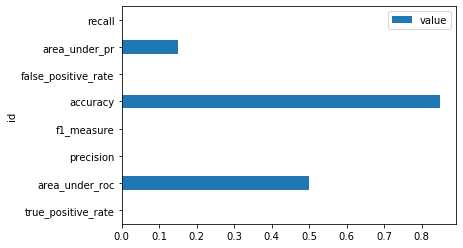

In [69]:
%matplotlib inline

quality_pd = subscription.quality_monitoring.get_table_content(format='pandas')
quality_pd.plot.barh(x='id', y='value');

### 4.9 Setup the Fairness Monitors

The code below configures fairness monitoring for our model. It turns on monitoring for two features, _conds(Weather Condition) and Traffic for the cell tower. In each case, we must specify:
  * Which model feature to monitor
  * One or more **majority** groups, which are values of that feature that we expect to receive a higher percentage of favorable outcomes
  * One or more **minority** groups, which are values of that feature that we expect to receive a higher percentage of unfavorable outcomes
  * The threshold at which we would like OpenScale to display an alert if the fairness measurement falls below (in this case, 95%)

Additionally, we must specify which outcomes from the model are favourable outcomes, and which are unfavourable. We must also provide the number of records OpenScale will use to calculate the fairness score. In this case, OpenScale's fairness monitor will run hourly, but will not calculate a new fairness rating until at least 5 records have been added. Finally, to calculate fairness, OpenScale must perform some calculations on the training data, so we provide the dataframe containing the data.

In [70]:
subscription.fairness_monitoring.enable(
            features=[
                Feature("Traffic", majority=['Low'], minority=['High','Medium'], threshold=0.95),
                Feature(" _conds", majority=['Haze','Rain'], minority=['Clear','Fog','Partly Cloudy'], threshold=0.95)
            ],
            favourable_classes=[1],
            unfavourable_classes=[0],
            min_records=5,
            training_data=df_data_1
        )

In [71]:
time.sleep(5)

run_details = subscription.fairness_monitoring.run(background_mode=False)




 Counting bias for deployment_uid=b68fd044-99b4-4465-8164-be6f8f034a4a 




RUNNING....
FINISHED WITH ERRORS

----------------------------------------------
 Run failed with status: FINISHED WITH ERRORS 
----------------------------------------------


Reason: AIQFM6004


In [72]:
time.sleep(5)

subscription.fairness_monitoring.show_table()

2019-09-25 08:23:50.090455+00:00,Traffic,High,False,1,0.0,9cbd5cc3-2844-4a00-9874-b572a337e8d6,497a4336-6142-4f41-b00c-249f48776a41,497a4336-6142-4f41-b00c-249f48776a41,b68fd044-99b4-4465-8164-be6f8f034a4a,
2019-09-25 08:23:50.090455+00:00,Traffic,Medium,False,1,0.0,9cbd5cc3-2844-4a00-9874-b572a337e8d6,497a4336-6142-4f41-b00c-249f48776a41,497a4336-6142-4f41-b00c-249f48776a41,b68fd044-99b4-4465-8164-be6f8f034a4a,
2019-09-25 08:23:50.090455+00:00,_conds,Fog,True,0.0,0.0,9cbd5cc3-2844-4a00-9874-b572a337e8d6,497a4336-6142-4f41-b00c-249f48776a41,497a4336-6142-4f41-b00c-249f48776a41,b68fd044-99b4-4465-8164-be6f8f034a4a,
2019-09-25 08:23:50.090455+00:00,_conds,Clear,False,1,0.0,9cbd5cc3-2844-4a00-9874-b572a337e8d6,497a4336-6142-4f41-b00c-249f48776a41,497a4336-6142-4f41-b00c-249f48776a41,b68fd044-99b4-4465-8164-be6f8f034a4a,
2019-09-25 08:23:50.090455+00:00,_conds,Partly Cloudy,False,1,0.0,9cbd5cc3-2844-4a00-9874-b572a337e8d6,497a4336-6142-4f41-b00c-249f48776a41,497a4336-6142-4f41-b00c-249f48776a41,b68fd044-99b4-4465-8164-be6f8f034a4a,


### Add some more Payload (Optional for populating your dashboard)

If you wish to add some Payload Data. Take different sections of your test dataset and send to OpenScale as shown below-

In [78]:
score=X_test.head(100)
score

,outgoing_site_id,Start_Time_MM_DD_YYYY,Start_Time_HH_MM_SS_s,Call_Service_Duration,_conds,_dewptm,_fog,_hail,_hum,_pressurem,total number_of_calls,total call duration (min),Traffic,lat,long,Call_Drop_Count,Total_Calls,Call_Drop_Perc
5711,63383,20/10/17,00:00 to 4:00,412,Haze,9,0,0,21,1011.0,376,645,Medium,12.972967,77.609317,11100,12234,0.907308
449,63383,20/03/17,12:00 to 16:00,36,Haze,13,0,0,50,1010.0,268,263,Medium,12.972967,77.609317,11100,12234,0.907308
1088,63383,14/07/17,12:00 to 16:00,39,Haze,27,0,0,79,1001.0,597,301,High,12.972967,77.609317,11100,12234,0.907308
5426,63383,31/08/17,4:00 to 8:00,462,Haze,27,0,0,75,1000.0,483,323,Medium,12.972967,77.609317,11100,12234,0.907308
8966,63383,25/05/17,00:00 to 4:00,17,Clear,13,0,0,22,1004.0,590,588,High,12.972967,77.609317,11100,12234,0.907308
4024,63383,22/12/17,12:00 to 16:00,344,Shallow Fog,10,1,0,77,1020.0,506,247,Medium,12.972967,77.609317,11100,12234,0.907308
9041,63383,07/06/17,4:00 to 8:00,411,Widespread Dust,17,0,0,22,993.0,230,438,Low,12.972967,77.609317,11100,12234,0.907308
11852,63383,24/10/17,12:00 to 16:00,470,Smoke,13,0,0,53,1011.0,389,452,Medium,12.972967,77.609317,11100,12234,0.907308
1379,63383,05/09/17,16:00 to 20:00,389,Mostly Cloudy,25,0,0,89,1004.0,186,414,Low,12.972967,77.609317,11100,12234,0.907308
4075,63383,31/12/17,8:00 to 12:00,353,Fog,9,1,0,88,1018.0,214,387,Low,12.972967,77.609317,11100,12234,0.907308


In [79]:
scoring_data=list(list(x) for x in zip(*(score[x].values.tolist() for x in score.columns)))
scoring_data

[[63383,
  '20/10/17',
  '00:00 to 4:00',
  412,
  'Haze',
  9,
  0,
  0,
  21,
  1011.0,
  376,
  645,
  'Medium',
  12.972967,
  77.609317,
  11100,
  12234,
  0.907307504],
 [63383,
  '20/03/17',
  '12:00 to 16:00',
  36,
  'Haze',
  13,
  0,
  0,
  50,
  1010.0,
  268,
  263,
  'Medium',
  12.972967,
  77.609317,
  11100,
  12234,
  0.907307504],
 [63383,
  '14/07/17',
  '12:00 to 16:00',
  39,
  'Haze',
  27,
  0,
  0,
  79,
  1001.0,
  597,
  301,
  'High',
  12.972967,
  77.609317,
  11100,
  12234,
  0.907307504],
 [63383,
  '31/08/17',
  '4:00 to 8:00',
  462,
  'Haze',
  27,
  0,
  0,
  75,
  1000.0,
  483,
  323,
  'Medium',
  12.972967,
  77.609317,
  11100,
  12234,
  0.907307504],
 [63383,
  '25/05/17',
  '00:00 to 4:00',
  17,
  'Clear',
  13,
  0,
  0,
  22,
  1004.0,
  590,
  588,
  'High',
  12.972967,
  77.609317,
  11100,
  12234,
  0.907307504],
 [63383,
  '22/12/17',
  '12:00 to 16:00',
  344,
  'Shallow Fog',
  10,
  1,
  0,
  77,
  1020.0,
  506,
  247,
  'Mediu

In [80]:
fields=list(X_test.columns)
print(len(fields))
fields, scoring_data[0]

18


(['outgoing_site_id',
  'Start_Time_MM_DD_YYYY',
  'Start_Time_HH_MM_SS_s',
  'Call_Service_Duration',
  ' _conds',
  ' _dewptm',
  ' _fog',
  ' _hail',
  ' _hum',
  ' _pressurem',
  'total number_of_calls',
  'total call duration (min)',
  'Traffic',
  'lat',
  'long',
  'Call_Drop_Count',
  'Total_Calls',
  'Call_Drop_Perc'],
 [63383,
  '20/10/17',
  '00:00 to 4:00',
  412,
  'Haze',
  9,
  0,
  0,
  21,
  1011.0,
  376,
  645,
  'Medium',
  12.972967,
  77.609317,
  11100,
  12234,
  0.907307504])

In [81]:
request_data = {
    "fields": fields,
    "values": scoring_data
  }
request_data

{'fields': ['outgoing_site_id',
  'Start_Time_MM_DD_YYYY',
  'Start_Time_HH_MM_SS_s',
  'Call_Service_Duration',
  ' _conds',
  ' _dewptm',
  ' _fog',
  ' _hail',
  ' _hum',
  ' _pressurem',
  'total number_of_calls',
  'total call duration (min)',
  'Traffic',
  'lat',
  'long',
  'Call_Drop_Count',
  'Total_Calls',
  'Call_Drop_Perc'],
 'values': [[63383,
   '20/10/17',
   '00:00 to 4:00',
   412,
   'Haze',
   9,
   0,
   0,
   21,
   1011.0,
   376,
   645,
   'Medium',
   12.972967,
   77.609317,
   11100,
   12234,
   0.907307504],
  [63383,
   '20/03/17',
   '12:00 to 16:00',
   36,
   'Haze',
   13,
   0,
   0,
   50,
   1010.0,
   268,
   263,
   'Medium',
   12.972967,
   77.609317,
   11100,
   12234,
   0.907307504],
  [63383,
   '14/07/17',
   '12:00 to 16:00',
   39,
   'Haze',
   27,
   0,
   0,
   79,
   1001.0,
   597,
   301,
   'High',
   12.972967,
   77.609317,
   11100,
   12234,
   0.907307504],
  [63383,
   '31/08/17',
   '4:00 to 8:00',
   462,
   'Haze',
   27

In [ ]:
## From the output of the above table choose your model name and copy the uid against it. Store the uid in the subscription_uid variable



from ibm_ai_openscale import APIClient4ICP
from ibm_ai_openscale.supporting_classes import PayloadRecord


subscription = ai_client.data_mart.subscriptions.get(subscription_uid=subscription_uid)

"""
request_data - input to scoring endpoint in supported by Watson OpenScale format
response_data - output from scored model in supported by Watson OpenScale format
response_time - scoring request response time [ms] (integer type)

Example:

request_data = {
    "fields": ["AGE", "SEX", "BP", "CHOLESTEROL", "NA", "K"],
    "values": [[28, "F", "LOW", "HIGH", 0.61, 0.026]]
  }

response_data = {
    "fields": ["AGE", "SEX", "BP", "CHOLESTEROL", "NA", "K", "probability", "prediction", "DRUG"],
    "values": [[28, "F", "LOW", "HIGH", 0.61, 0.026, [0.82, 0.07, 0.0, 0.05, 0.03], 0.0, "drugY"]]
  }
"""



records = [PayloadRecord(request=request_data, response=scoring_response, response_time=18), 
                PayloadRecord(request=request_data, response=scoring_response, response_time=12)]

subscription.payload_logging.store(records=records)